# Mice data exercise

Use the mice data you filtered in the exercise of GWAS3, or if you do not have it, use the initial mice data.

**1 - Calculate the kinship matrix and plot the values on the histogram.**



<img src="../Images/bash.png" alt="Bash" width="40"> Switch to the bash kernel

In [3]:
ln -sf ../../Data
mkdir -p Results/GWAS4

We will use the mice data undrgoing QC from the previous exercise (You can also use the initial mice data if you want). We apply `--make-king-table` option in PLINK2 to calculate the KING kinship matrix.

In [4]:
plink2 --bfile Results/GWAS3/mice_QCA \
       --make-king-table \
       --out Results/GWAS4/KING

PLINK v2.00a5.12LM 64-bit Intel (25 Jun 2024)  www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS4/KING.log.
Options in effect:
  --bfile Results/GWAS3/mice_QCA
  --make-king-table
  --out Results/GWAS4/KING

Start time: Fri Mar 28 12:47:56 2025
385567 MiB RAM detected, ~334696 available; reserving 192783 MiB for main
workspace.
Using up to 64 threads (change this with --threads).
1926 samples (0 females, 0 males, 1926 ambiguous; 1926 founders) loaded from
Results/GWAS3/mice_QCA.fam.
2439 variants loaded from Results/GWAS3/mice_QCA.bim.
Note: No phenotype data present.
--make-king-table pass 1/1: Scanning for rare variants... done.
0 variants handled by initial scan (2439 remaining).
--make-king-table pass 1/1: Writing... done.
--make-king-table: 2439 variants processed.
Results written to Results/GWAS4/KING.kin0 .
End time: Fri Mar 28 12:47:57 2025


Remember that the table from PLINK2 contains: 

- `FID1`: Family ID of the first individual.
- `IID1`: Individual ID of the first individual.
- `FID2`: Family ID of the second individual.
- `IID2`: Individual ID of the second individual.
- `NSNP`: The number of SNPs used to calculate the kinship between the two individuals.
- `HETHET`: The number of heterozygous sites used in the kinship calculation (often useful for checking genotyping quality).
- `IBS0`: The number of identical-by-state (IBS) 0 SNPs, which are variants where the two individuals do not share the same allele.
- `KINSHIP`: The kinship coefficient between the two individuals, which is the proportion of alleles shared by descent.

 Let's print the first few rows of `KING.kin0` and then, the unique relatioship categories in the file: 

In [5]:
cat Results/GWAS4/KING.kin0 | head -5

#FID1	IID1	FID2	IID2	NSNP	HETHET	IBS0	KINSHIP
A048006063	A048006063	A048005080	A048005080	2439	0.177122	0.0561706	0.0543033
A048006555	A048006555	A048005080	A048005080	2439	0.222632	0.0418204	0.145492
A048006555	A048006555	A048006063	A048006063	2439	0.211152	0.0606806	0.1
A048007096	A048007096	A048005080	A048005080	2439	0.207052	0.0471505	0.101434


It looks like there are mostly related pairs!

In [4]:
awk '{ if ($8 > 0.2) print $2}' Results/GWAS4/KING.kin0 | sort | uniq | wc -l

1785


:::

---------------

Generation of the plot of KING values

<img src="../Images/R.png" alt="R" width="40"> Switch to the R kernel.


In [1]:
suppressMessages(suppressWarnings(library(ggplot2)))

options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
relatedness <- read.table("Results/GWAS4/KING.kin0", header=TRUE, comment.char = '|')

head(relatedness)

,X.FID1,IID1,FID2,IID2,NSNP,HETHET,IBS0,KINSHIP
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,A048006063,A048006063,A048005080,A048005080,2439,0.177122,0.0561706,0.0543033
2,A048006555,A048006555,A048005080,A048005080,2439,0.222632,0.0418204,0.1454920
3,A048006555,A048006555,A048006063,A048006063,2439,0.211152,0.0606806,0.1000000
4,A048007096,A048007096,A048005080,A048005080,2439,0.207052,0.0471505,0.1014340
5,A048007096,A048007096,A048006063,A048006063,2439,0.220172,0.0434604,0.1388890
6,A048007096,A048007096,A048006555,A048006555,2439,0.223042,0.0356704,0.1602210


**That is a crazy histograms!**

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


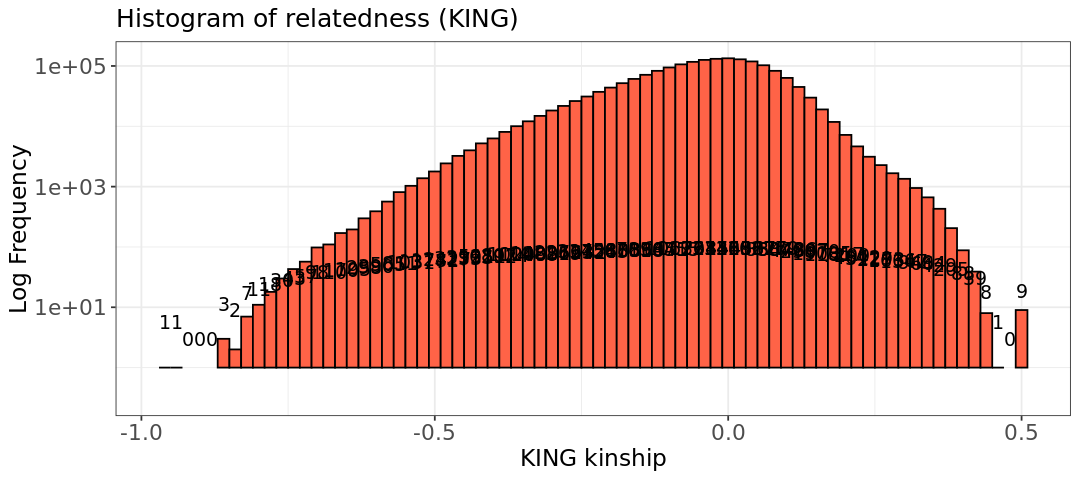

In [2]:
hist.king <- ggplot(relatedness, aes(x=relatedness[,8])) +
  geom_histogram(binwidth = 0.02, col = "black", fill="tomato") + 
  labs(title = "Histogram of relatedness (KING)") + 
  xlab("KING kinship") + 
  ylab("Log Frequency") + 
  theme_bw() +
  scale_y_log10() +
  theme(axis.title=element_text(size=14), 
        axis.text=element_text(size=13),
        plot.title=element_text(size=15)) 

#Extract coordinates of the plot
bin_data <- ggplot_build(hist.king)$data[[1]]

#Adding text labels to  each bar, 
#accounting for log scale
hist.king + 
  geom_text(data = bin_data, 
            aes(x = xmin + (xmax - xmin) / 2, 
                y = log10(count+1),  # Apply log10
                label = count), 
                vjust = -5, #Vertical adjustment of text
                size = 4, 
                color = "black")

The quality seems however good - around same number of SNPs has been used for all samples (this plot takes some time as there are hundreds of thousands of points).

Warning message:
“Removed 564631 rows containing missing values or values outside the scale range
(`geom_point()`).”


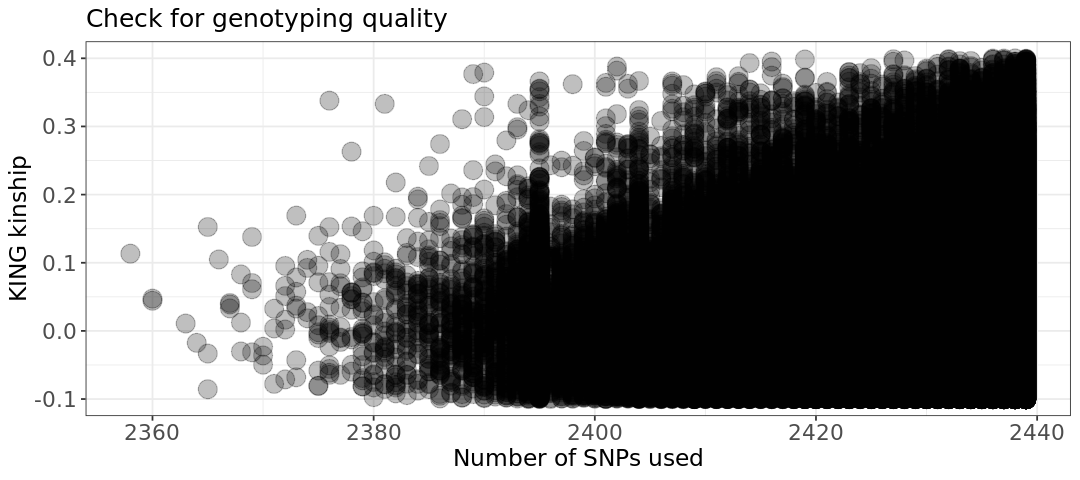

In [3]:
# Relatedness plot
plot.relatedness <- ggplot(relatedness) +
  geom_point(aes(x=NSNP, y=KINSHIP), size=5, alpha=.25) + 
  ylim(-.1,.4) +
  labs(x = "Number of SNPs used", y = "KING kinship", title = "Check for genotyping quality") + 
  theme_bw() +
  theme(axis.title=element_text(size=14), 
        axis.text=element_text(size=13), 
        legend.text= element_text(size=13), 
        legend.title=element_text(size=14), 
        plot.title=element_text(size=15))

show(plot.relatedness)

**2 - Why do you get those values in the plot? What could be happening? Remember those are mice!**

One possibility for getting such a crazy histogram is that the individuals have a lot of inbreeding. This is indeed our case: all mice come from only eight founders! The KING estimator assumes outbred populations, which is usually the case for humans. Another thing that can happen in this scenario, is that a founder is responsible for many of the descendants. This will create so many differences in genotype frequencies, that KING gets negative value, which would mean *pairs with very negative relatedness*, almost creating an outgroup within the dataset

**3 - Now try instead to use `plink` with the option `--genome`. This calculates the IBD estimator called pi_hat. You need `--bfile` for the input data and `--out` for the name of the output table.**

<img src="../Images/bash.png" alt="R" width="40"> Switch to the bash kernel.

In [2]:
plink --bfile Results/GWAS3/mice_QCA \
      --genome \
      --out Results/GWAS4/pihat

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS4/pihat.log.
Options in effect:
  --bfile Results/GWAS3/mice_QCA
  --genome
  --out Results/GWAS4/pihat

385567 MB RAM detected; reserving 192783 MB for main workspace.
2439 variants loaded from .bim file.
1926 people (0 males, 0 females, 1926 ambiguous) loaded from .fam.
Ambiguous sex IDs written to Results/GWAS4/pihat.nosex .
Using up to 63 threads (change this with --threads).
Before main variant filters, 1926 founders and 0 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate is 0.999187.
2439 variants and 1926 people pass filters and QC.
Note: No phenotypes present.
IBD calculations complete.  
Finished writing Results/GWAS4/pihat.genome .


4 - Plot again the histogram using the table (column PI_HAT). Now you should have values bounded between (0,1) on the x axis.

<img src="../Images/R.png" alt="R" width="40"> Switch to the R kernel.


In [1]:
# Generate a plot to assess the type of relationship.
suppressMessages(suppressWarnings(library(ggplot2)))

options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
relatedness <- read.table("Results/GWAS4/pihat.genome", header=TRUE)

head(relatedness)

,FID1,IID1,FID2,IID2,RT,EZ,Z0,Z1,Z2,PI_HAT,PHE,DST,PPC,RATIO
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,A048005080,A048005080,A048006063,A048006063,UN,NA,0.6232,0.3768,0.0000,0.1884,-1,0.699467,0.9996,3.2500
2,A048005080,A048005080,A048006555,A048006555,UN,NA,0.5372,0.4204,0.0424,0.2526,-1,0.758098,1.0000,4.2692
3,A048005080,A048005080,A048007096,A048007096,UN,NA,0.5635,0.4365,0.0000,0.2183,-1,0.728167,1.0000,4.1887
4,A048005080,A048005080,A048010273,A048010273,UN,NA,0.3277,0.6723,0.0000,0.3361,-1,0.745182,1.0000,5.1176
5,A048005080,A048005080,A048010371,A048010371,UN,NA,1.0000,0.0000,0.0000,0.0000,-1,0.677400,0.3059,1.8659
6,A048005080,A048005080,A048011040,A048011040,UN,NA,0.5661,0.4339,0.0000,0.2170,-1,0.736162,1.0000,4.1702


Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


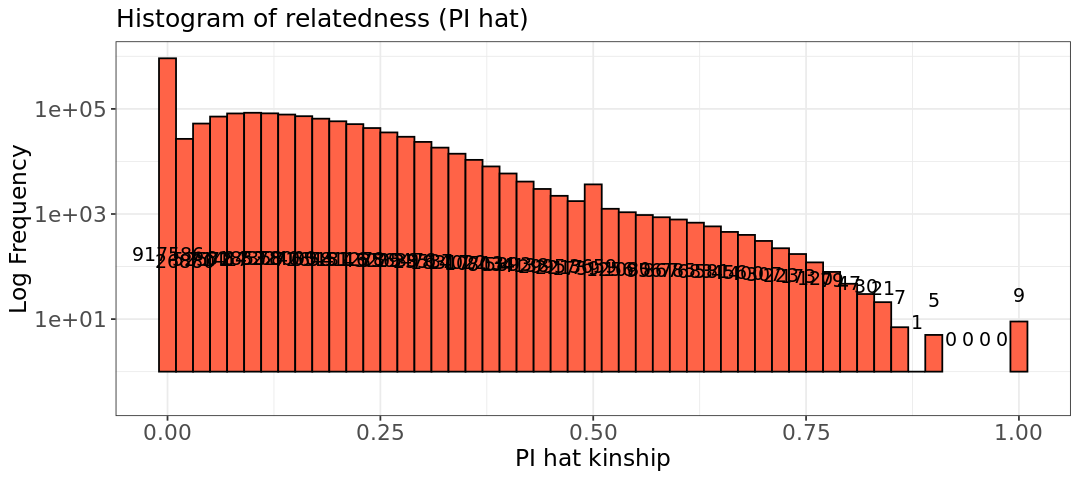

In [2]:
hist.king <- ggplot(relatedness, aes(x=PI_HAT)) +
  geom_histogram(binwidth = 0.02, col = "black", fill="tomato") + 
  labs(title = "Histogram of relatedness (PI hat)") + 
  xlab("PI hat kinship") + 
  ylab("Log Frequency") + 
  theme_bw() +
  scale_y_log10() +
  theme(axis.title=element_text(size=14), 
        axis.text=element_text(size=13),
        plot.title=element_text(size=15)) 

#Extract coordinates of the plot
bin_data <- ggplot_build(hist.king)$data[[1]]

#Adding text labels to  each bar, 
#accounting for log scale
hist.king + 
  geom_text(data = bin_data, 
            aes(x = xmin + (xmax - xmin) / 2, 
                y = log10(count+1),  # Apply log10
                label = count), 
                vjust = -5, #Vertical adjustment of text
                size = 4, 
                color = "black")

**6 - Values around 0.25 are second-degree relationships (half siblings), around 0.5 are parent-child and siblings. Usually, a pi_hat much above 0.5 is trace of duplicates, or inbreeding (the second is likely our case, or we would have really bad data with too many duplicates). We have also some sample pairs with a pi_hat=1. What could those samples be?**

Those could be pairs of twins!